# Лабораторная работа №3. Линейные модели для классификации

В задачах классификации, в отличие от задач регрессии, требуется по образу объекта определить его принадлежность к тому или иному классу.
В данной работе будет рассмотрена только задача бинарной (двухклассовой) классификации.
В качестве ответа классификатора используется
$$
P(C_1 | \mathbf\phi) = \sigma( \mathbf{w}^T \mathbf\phi),
$$
где
$$
\sigma(a) = \frac{1}{1 + \mathrm{e}^{-a}}.
$$
 
В случае логистической регрессии минимизируется функция штрафа
$$
E(\mathbf{w}) = -\sum_{n=1}^N\left( t_n \ln y_n + (1 - t_n) \ln (1 - y_n) \right).
$$

Её градиент равен
$$
\nabla E(\mathbf{w}) = \sum_{n=1}^N (y_n - t_n) \mathbf\phi(\mathbf{x}_n) =
\sum_{n=1}^N \left( \sigma(\mathbf{w}^T\mathbf\phi_n) - t_n \right) \mathbf\phi_n = \mathbf\Phi^T (\mathbf{y} - \mathbf{T}),
$$
где $\mathbf{y} = (y_1, \dots, y_N)^T$ $-$ отклики распознавателя, $\mathbf{T} = (t_1, \dots, t_N)^T$ $-$ метки классов.
 
Выпишем классический метод градиентного спуска в матричной форме:
$$
\mathbf{w}_{i+1} = \mathbf{w}_i - \alpha\nabla E,\;\;\; i = 1, 2, \dots,
$$
где $\mathbf{w}_0$ задано, а $\nabla E = \nabla E(\mathbf{w}_i, T)$.
Заметим, что здесь $T = \left\{ (\mathbf{x}_k, t_k) \right\}_{k=1}^N$.
То есть в итерационной процедуре на каждой итерации для расчета $\nabla{E}$ используются вся выборка целиком.

Будем теперь вместо полной выборки $T = \left\{ (\mathbf{x}_k, t_k) \right\}_{k=1}^N$ на каждой итерации случайно выбирать $K$ элементов из T:
$T_i = \left( (\mathbf{x}_{i_1}, t_{i_1}), (\mathbf{x}_{i_2}, t_{i_2}), \dots, (\mathbf{x}_{i_K}, t_{i_K}) \right)$.
Назовем $T_i$ пакетом или пачкой (batch).
Индекс $i$ отражает то, что пакет векторов из обучающей выборки выбирается отдельно на каждой итерации.

При $K = 1$ получаем так называемый _стохастический градиентный спуск_ (stochastic gradient descent, SGD).

При $K = N$ используется вся выборка, получаем _классический метод градиентного спуска_ (vanilla gradient descent).

В остальных случаях ($1 < K < N$) метод называют _mini-batch gradient descent_.

На практике обычно _mini-batch gradient descent_ сходится быстрее, чем _vanilla gradient descent_.

Вместе со стохастическим градиентным спуском часто применяют момент.
Момент не позволяет резко измениться направлению спуска.
Это позволяет достичь более плавного и быстрого спуска.
В ряде случаев использование момента также позволяет не «свалиться» в локальный минимум.

**Momentum**.
Итерационный поиск осуществляется по следующему алгоритму:
$$
\begin{gather}
    \mathbf{w}_{i+1} = \mathbf{w}_i + \mathbf{v}_i,\;\;\; i = 1, 2, \dots, \\
    \mathbf{v}_i = \gamma \mathbf{v}_{i-1} - \alpha \nabla{E} \left( \mathbf{w}_i, (\mathbf{x}_{k_i}, t_{k_i}) \right), \\
    \mathbf{v}_0 = 0.
\end{gather}
$$

Для параметра $\gamma$ обычно выбирается значение 0.9 или близкое к этому.

In [1]:
import numpy as np
import sklearn as sk
from sklearn import datasets, model_selection, metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import timeit

mpl.rcParams['axes.grid'] = True

## Задание №1

Разделите выборку на обучающую и тестовую.
Размер тестовой выборки - 20% от размера исходной выборки.
Параметр `n_features` определяется как `3 + mod(<порядковый номер в списке>, 3)`, `n_samples` необходимо взять `600 - 100 * mod(<порядковый номер в списке>, 3)`.

In [2]:
x, y = sk.datasets.make_classification(n_samples=500, n_features=4, random_state=145)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state=43, test_size = 0.2)
print(x_train.shape, y_train.shape)

(400, 4) (400,)


## Задание №2

Реализуйте алгоритм _mini-batch gradient descent_.
В качестве критерия выхода возьмите ограничение по количеству эпох.

In [30]:
class GradientDescent:
    def __init__(self, batch_size, alpha=1e-3, eps=1e-6, epoch=100):
        self.rng = np.random.default_rng(seed=489);
        self.batch_size = batch_size
        self.alpha = alpha
        self.eps = eps
        self.epoch = epoch
        
    
    def fit(self, x, y, val_x, val_y):
        self.w = self.rng.uniform(low=-1, high=1, size=(x.shape[1] + 1, 1))
        self.loss, self.precision = [], []
        self.val_loss, self.val_precision = [], []
        self.labels = np.unique(y)
        
        ones = np.ones((len(y),1))
        ones_val = np.ones((len(val_y),1))

        xx = np.concatenate((ones, x), axis = -1)
        yy = np.asarray(y).reshape(-1,1)
        val_xx = np.concatenate((ones_val, val_x), axis = -1)
        val_yy = np.asarray(val_y).reshape(-1,1) 
        idxs = range(0, xx.shape[0], self.batch_size)
        for i in range(self.epoch):
            order = np.random.permutation(len(xx))
            for idx in idxs:
                batch_indexes = order[idx:idx+self.batch_size]
                x_batch = xx[batch_indexes]
                y_batch = yy[batch_indexes]
                
                deriv = x_batch.T @ (self.predict_proba(x_batch) - y_batch)
                self._update(deriv)

            self.loss.append(sk.metrics.log_loss(yy, self.predict_proba(xx)))
            self.precision.append(sk.metrics.accuracy_score(yy, self.forward(xx)))
            self.val_loss.append(sk.metrics.log_loss(val_yy, self.predict_proba(val_xx)))
            self.val_precision.append(sk.metrics.accuracy_score(val_yy, self.forward(val_xx)))
   
    def _update(self, deriv):
        self.w -= self.alpha * deriv

    def predict_proba(self, x):
        return (1 / (1 + np.exp(-x @ self.w)))
    
    def forward(self, x):
        return np.round(self.predict_proba(x))

    def __call__(self, x):
        ones = np.ones((x.shape[0],1))
        xx = np.concatenate((ones, x), axis = -1)
        return self.forward(xx)

# Тестирование

test_x = np.array([[1, 1, 1], [2, 4, 16], [3, 9, 27]])
gd = GradientDescent(batch_size=10, epoch = 400)
gd.fit(test_x, np.array([1, 0, 1]), val_x=test_x, val_y=np.array([1, 0, 1]))
print("Response", gd(test_x))
assert sk.metrics.precision_score(gd(test_x), [1, 0, 1]) == 1.0, 'Метод недостаточно точный'
assert sk.metrics.accuracy_score(gd(test_x), [1, 0, 1]) > 0.6, 'Метод недостаточно точный'

Response [[1.]
 [0.]
 [1.]]


## Задание №3

Протестируйте написанный алгоритм, подберите параметры градиентного спуска, дающие после обучения классификатор с наилучшей точностью
($\text{точность} = \frac{\text{количество правильно классифицированных векторов}}{\text{количество векторов}}$).
Сравните классический градиентный спуск, стохастический и mini-batch.
Для начала возьмите следующие параметры:

* случайные начальные значения весов (равномерное распределение на отрезке $[-1; 1]$ для каждой компоненты);
* размер шага обучения $\alpha = 10^{-5}$;
* размер пакета _batch size_ = 20;
* максимальное количество эпох 1000.

Приведите в отчет полученную точность и значение функции штрафа на тестовой и обучающей выборках.
Постройте графики для каждого тестируемого размера батча:

* зависимость функции штрафа на обучающей и тестовой выборках от номера эпохи;
* зависимость точности на обучающей и тестовой выборках от номера эпохи;
* зависимость времени выполнения алгоритма от размера батча.

Batch size = 1, precision = 0.9285714285714286
Batch size = 20, precision = 0.9285714285714286
Batch size = 50, precision = 0.9285714285714286
Batch size = 100, precision = 0.9285714285714286
Batch size = 400, precision = 0.9285714285714286
Wall time: 20.5 s


Text(0.5, 1.0, 'Зависимость времени обучения от размера батча')

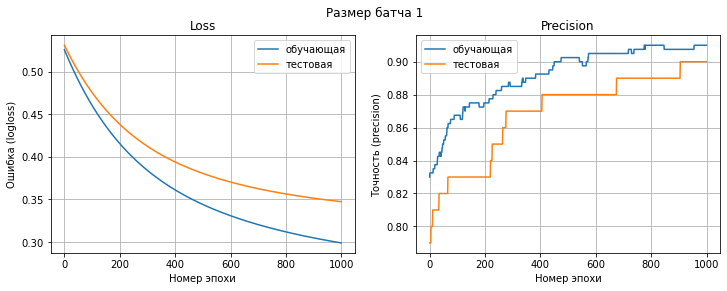

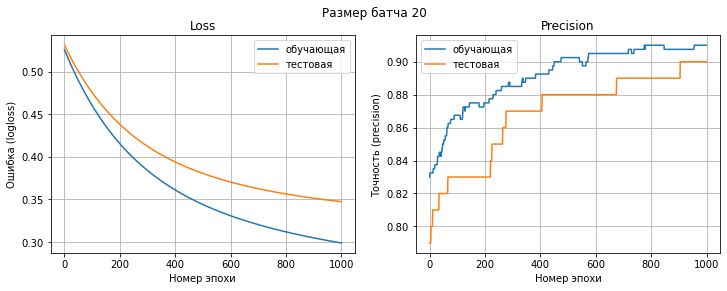

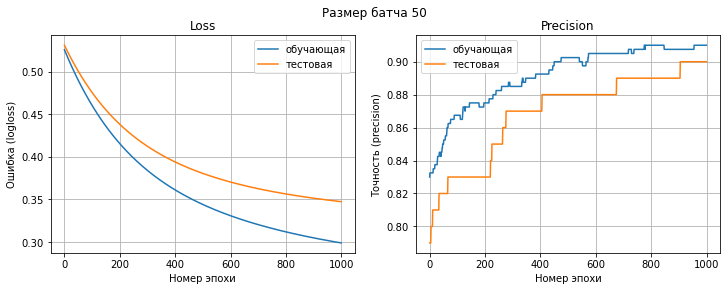

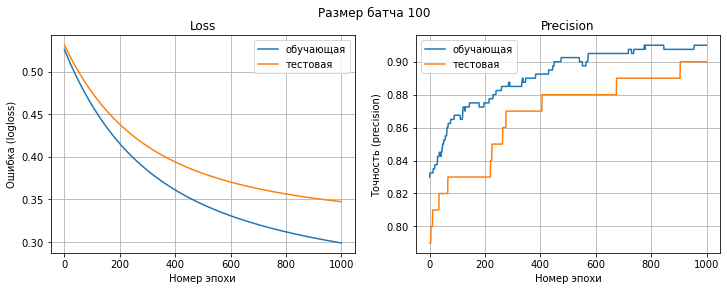

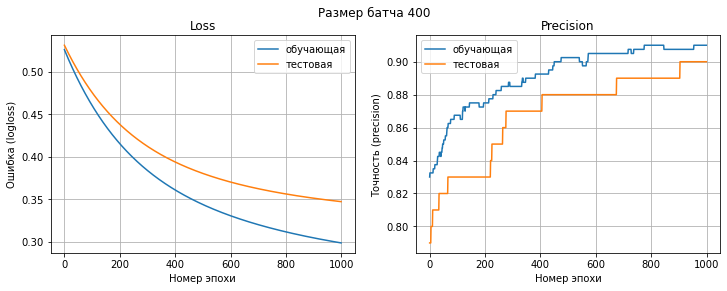

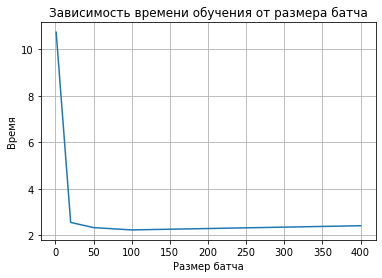

In [33]:
%%time

times = {}
for batch in [1, 20, 50, 100, x_train.shape[0]]:
    gd = GradientDescent(batch, epoch=1000, alpha=1e-5)
    t = timeit.default_timer()
    gd.fit(x_train, y_train, val_x=x_test, val_y=y_test)
    times[batch] = timeit.default_timer() - t
    y_pred = gd(x_test)
    print(f"Batch size = {batch}, precision = {sk.metrics.precision_score(y_test, y_pred)}")
    
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
    ax0.plot(range(len(gd.loss)), gd.loss, label='обучающая')
    ax0.plot(range(len(gd.val_loss)), gd.val_loss, label='тестовая')
    ax0.set(xlabel='Номер эпохи', ylabel='Ошибка (logloss)', title='Loss')
    ax0.legend()
    ax1.plot(range(len(gd.precision)), gd.precision, label='обучающая')
    ax1.plot(range(len(gd.val_precision)), gd.val_precision, label='тестовая')
    ax1.set(xlabel='Номер эпохи', ylabel='Точность (precision)', title='Precision')
    ax1.legend()
    fig.suptitle(f"Размер батча {batch}")
    
plt.figure()
plt.plot(times.keys(), times.values()) # python3.7+
plt.xlabel('Размер батча')
plt.ylabel('Время')
plt.title('Зависимость времени обучения от размера батча')

**Вопросы**

1. Зависит ли точность от размера батча? Почему?
1. Зависит ли время работы алгоритма от размера батча? Почему?

**Ответы**

1. Для данной задачи точность от размера батча не зависит. Т. к. здесь веса модели быстро сходятся к оптимальным значениям для всех рассмотренных размеров батча, в результате чего итоговая точность везде получается одинаковой.
1. Время работы алгоритма не зависит от размера батча. Т. к. работа алгоритма всегда состоит в вычислении отклика логистической функции от скалярного произведения вектора входных данных на вектор весов, которые для каждой конкретной модели являются постоянными. Но от размера батча зависит время обучения модели, т. к. при маленьких размерах батча обучение требует большего числа итераций градиентного спуска. Наименьшее время обучения наблюдается при размере батча, равном 100. Но оно также зависит и от разрядности векторных регистров компьютера, за счёт использования которых можно ускорить вычисления, и поэтому может отличаться для конкретной машины, на которой обучается модель.

## Задание №4

Реализуйте метод оптимизации градиентного спуска _momentum_.
Примените наследование от `GradientDescent` и перегрузите метод `_update`, в котором происходят обновления весов модели.

In [39]:
class MomentumGD(GradientDescent):
    def __init__(self, gamma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gamma = gamma
        
    def fit(self, x, *args, **kwargs):
        self.v = 0
        super().fit(x, *args, **kwargs)
    
    def _update(self, err):
        self.v = self.gamma * self.v - self.alpha * err
        self.w += self.v

## Задание №5

Подберите параметры, дающие улучшение сходимости (в большей степени это относится к параметру $\gamma$).  

* Сравните скорость сходимости со скоростью в задании 3.
Для этого постройте графики, на которых сравниваются скорости сходимости и качества модели для **обучающей** выборки.
* Сравните достигнутую точность с точностью в задании 3.
Удалось ли лучше обучить модель?
Чтобы эксперимент был «честным» следует запускать все методы с одними и теми же параметрами и с одними и теми же начальными значениями весов.

Gamma = 0.1, precision = 0.9285714285714286
Gamma = 0.3, precision = 0.9285714285714286
Gamma = 0.6, precision = 0.9285714285714286
Gamma = 0.9, precision = 0.9272727272727272
Gamma = 1.0, precision = 0.9230769230769231
Wall time: 15 s


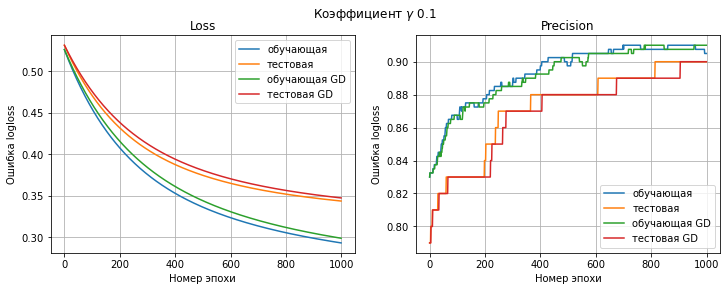

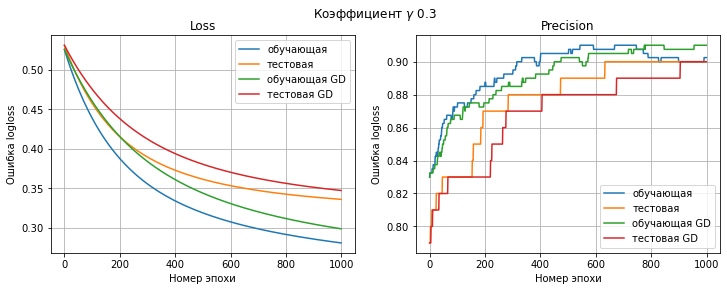

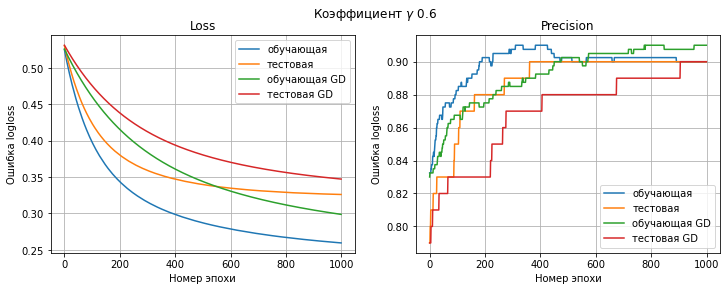

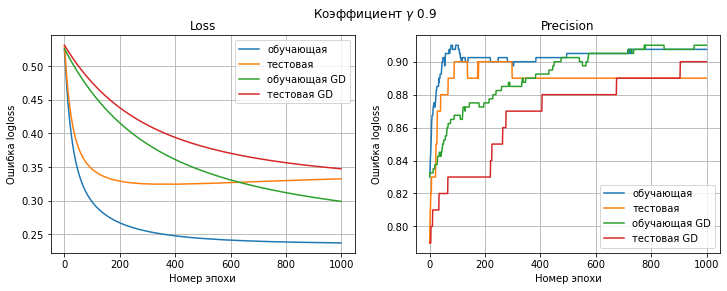

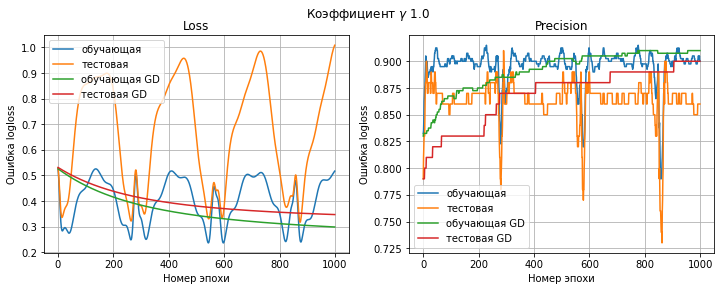

In [50]:
%%time

gd0 = GradientDescent(batch_size=50, epoch=1000, alpha=1e-5)
gd0.fit(x_train, y_train, val_x=x_test, val_y=y_test)

for gamma in [0.1, 0.3, 0.6, 0.9, 1.0]:
    gd = MomentumGD(gamma=gamma, batch_size = 50, epoch=1000, alpha=1e-5)
    gd.fit(x_train, y_train, val_x=x_test, val_y=y_test)
    y_pred = gd(x_test)
    print(f"Gamma = {gamma}, precision = {sk.metrics.precision_score(y_test, y_pred)}")
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
    ax0.plot(range(len(gd.loss)), gd.loss, label='обучающая')
    ax0.plot(range(len(gd.val_loss)), gd.val_loss, label='тестовая')
    ax0.plot(range(len(gd0.loss)), gd0.loss, label='обучающая GD')
    ax0.plot(range(len(gd0.val_loss)), gd0.val_loss, label='тестовая GD')
    ax0.set(xlabel='Номер эпохи', ylabel='Ошибка logloss', title='Loss')
    ax0.legend()
    ax1.plot(range(len(gd.precision)), gd.precision, label='обучающая')
    ax1.plot(range(len(gd.val_precision)), gd.val_precision, label='тестовая')
    ax1.plot(range(len(gd0.precision)), gd0.precision, label='обучающая GD')
    ax1.plot(range(len(gd0.val_precision)), gd0.val_precision, label='тестовая GD')
    ax1.set(xlabel='Номер эпохи', ylabel='Ошибка logloss', title='Precision')
    ax1.legend()
    fig.suptitle(f"Коэффициент $\gamma$ {gamma}")

**Вопросы**

1. Какой из алгоритмов быстрее достигает итоговой точности?
1. С ростом коэффициента $\gamma$ алгоритм сходится быстрее или медленее?
1. Что происходит при очень большом коэффициенте $\gamma$?

**Ответы**

1. По графикам видно, что _momentum_ быстрее достигает итоговой точности. Однако при неудачном подборе параметра $\gamma$ ($\gamma = 0.9$, $\gamma = 1.0$) итоговая точность может оказаться меньше, чем при обычном градиентном спуске.
1. При маленьких значениях коэффициента $\gamma$ скорость сходимости _momentum_ практически не отличается от скорости сходимости обычного градиентного спуска. С ростом параметра скорость сходимости начинает постепенно увеличиваться. Однако при слишком больших значениях ($\gamma = 0.9$) _momentum_ может сойтись либо к значениям весов, которые обеспечивают меньшую точность, чем при обычном градиентном спуске, либо (при $\gamma = 1.0$) вообще не сойтись, что видно по последним двум графикам.
1. При очень больших значениях коэффицента $\gamma$, значения вектора антиградиента прошлых итераций вносят большой вклад в изменение весов модели, из-за чего алгоритм поиска минимума функции потерь не может сойтись.

## Задание №6

Для какой-либо из обученных моделей постройте график, на котором изображено разделение пространства признаков на две области.
Проверьте, что разделяющая поверхность - линейная.

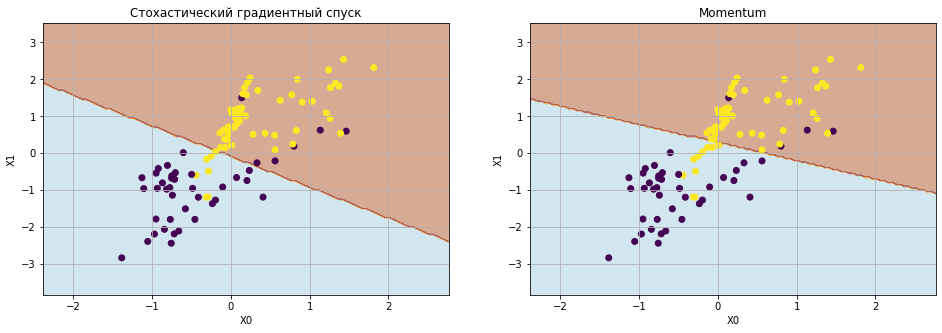

In [64]:
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
Z1 = gd0(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])
Z2 = gd(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))

ax0.contourf(xx, yy, Z1.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
ax0.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax0.set(xlabel='X0', ylabel='X1', title='Стохастический градиентный спуск');

ax1.contourf(xx, yy, Z2.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
ax1.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax1.set(xlabel='X0', ylabel='X1', title='Momentum');

## Задание №7

Классы в выборке не являются линейно разделимыми.
С данной проблемой можно бороться, воздействуя какой-то функцией на старые признаки:
$$
\mathbf{\phi}(\mathbf{x}) = \left( \phi_1(x_1, \dots, x_n), \dots, \phi_n(x_1, \dots, x_n) \right)^T.
$$

Покажите, как изменяется разделяющая поверхность, если задавать разную функцию отображения.
Постройте график, на котором изображено разделение пространства признаков и приведите величину достигнутой точности на тестовой выборке.
Попробуйте добиться лучшей точности (необязательно).

Score = 0.98
Wall time: 2.39 s


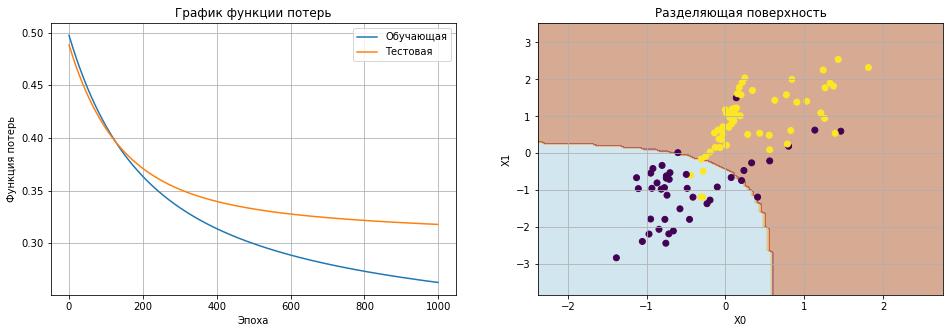

In [127]:
%%time

class MGD(GradientDescent):
    def _func(self, x):
        return np.exp(x)
    
    def fit(self, x, y, val_x, val_y):
        super().fit(self._func(x), y, self._func(val_x), val_y)
    
    def __call__(self, x):
        return super().__call__(self._func(x))

gdx = MGD(batch_size=50, epoch=1000, alpha=1e-5)
gdx.fit(x_train, y_train, x_test, y_test)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))

ax0.plot(range(len(gdx.loss)), gdx.loss, label='Обучающая')
ax0.plot(range(len(gdx.val_loss)), gdx.val_loss, label='Тестовая')
ax0.set(xlabel='Эпоха', ylabel='Функция потерь', title='График функции потерь');
ax0.legend()

Z = gdx(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])
ax1.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)

ax1.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax1.set(xlabel='X0', ylabel='X1', title='Разделяющая поверхность');

print("Score =", sk.metrics.precision_score(y_test, gdx(x_test)))

**Выводы**:

1. Для ускорения обучения модели бывает полезно предварительно разбить обучающий набор данных на пакеты (батчи) и проводить обучение по этим пакетам, а не по отдельным элементам обучающего набора. Причём размер пакета предпочтительнее выбирать настолько большим, насколько это позволяют располагаемые ресурсы.
1. Использование градиентного спуска с _momentum_ также позволяет ускорить обучение, сокращая количество эпох, за которое достигается наибольшая точность. Однако для этого необходимо правильно подобрать значение параметра $\gamma$.
1. Перед непосредственным применением модели бывает полезно использовать предварительное отображение входных данных. Это изменит вид разделяющей поверхности классов, что в некоторых случаях может привести к увеличению точности предсказания.